# Data Processing

## Importing the libraries

In [1]:
import pandas as pd
import networkx as nx
import json
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import pprint
from networkx.readwrite import json_graph

Read the CSV File downloaded

In [2]:
df = pd.read_csv("data/data_scopus.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Title                      570 non-null    object 
 1   Year                       570 non-null    int64  
 2   EID                        570 non-null    object 
 3   Abstract                   570 non-null    object 
 4   Publisher                  345 non-null    object 
 5   Conference name            423 non-null    object 
 6   Conference date            423 non-null    object 
 7   Authors                    570 non-null    object 
 8   Author(s) ID               570 non-null    object 
 9   Authors with affiliations  561 non-null    object 
 10  Source title               570 non-null    object 
 11  Abbreviated Source Title   568 non-null    object 
 12  Cited by                   385 non-null    float64
dtypes: float64(1), int64(1), object(11)
memory usage: 

## Drop the rows and replace the null values

Drop the rows with no Author Affiliations and replace NaN values by 0

In [4]:
df= df[~pd.isnull(df['Authors with affiliations'])].copy()
df['Cited by'] = df['Cited by'].fillna(0)

In [5]:
df.head(2)

,Title,Year,EID,Abstract,Publisher,Conference name,Conference date,Authors,Author(s) ID,Authors with affiliations,Source title,Abbreviated Source Title,Cited by
0,Virtual reality applications for the built env...,2020,2-s2.0-85086464158,With its advanced capabilities of immersive an...,Elsevier B.V.,NaN,NaN,"Zhang Y., Liu H., Kang S.-C., Al-Hussein M.",57202536919;53984550800;57215426514;6603541102;,"Zhang, Y., Department of Civil and Environment...",Automation in Construction,Autom Constr,0.0
1,"Self-tracking while doing sport: Comfort, moti...",2020,2-s2.0-85082875828,The spread of wearable technologies is paving ...,Academic Press,NaN,NaN,"Rapp A., Tirabeni L.",23398572100;57191836654;,"Rapp, A., Computer Science Department, Univers...",International Journal of Human Computer Studies,Int J Hum Comput Stud,0.0


Split the authors from Author(s) ID Column

In [6]:
def get_authors(x):
    authors_list = x[:-1].split(";")
    authors = [author.split(",")[0].strip() for author in authors_list]
    return authors_list
df['AID'] = df['Author(s) ID'].apply(get_authors)

Create a list with all unique Author IDs with number of citations for each author

In [7]:
authors_flat_list = []
for items in df['AID']:
  for author in items:
    if len(author)>0:
        author_citations = df[df['Author(s) ID'].str.contains(author, na=False)]['Cited by'].sum(),
        authors_flat_list.append((author,author_citations))

In [8]:
len(authors_flat_list)

1879

## Create a network using NetworkX

In [9]:
G = nx.Graph()

Some country does not have any country present in the data. Explored the internet and got their country names from their profiles. We will map them and add the other details to the nodes

In [10]:
country_info_list = [ ('6602173002' , 'United States'), ('6701855101' , 'United States'), ('7003497864' , 'United States'), 
                     ('7003538943' , 'United States'), ('7003588954' , 'Germany'), ('7004325039' , 'United States'), 
                     ('7004562694' , 'United States'), ('7006313615' , 'United States'), ('7006823587' , 'United States'), 
                     ('7006832588' , 'United States'), ('7102607078' , 'United States'), ('7201387294' , 'United States'), 
                     ('7201593410' , 'United States'), ('7201900328' , 'United States'), ('7403669974' , 'United States'), 
                     ('8213137900' , 'United States'), ('8897578200' , 'United States'), ('8969426800' , 'United States'), 
                     ('9134075300' , 'United States'), ('14631652200' , 'Canada'), ('35242298500' , 'United States'), 
                     ('35361180100' , 'United States'), ('55914125200' , 'Italy'), ('57196830795' , 'United States'), 
                     ('57196905130' , 'United States'), ('57197601225' , 'United States'), ('57213238810' , 'United States'), 
                     ('57213664077' , 'Germany'), ('57213671185' , 'Germany') ]

## Add Nodes (Authors)

In [11]:
nodes = []

for index, row in df.iterrows():
    authors = row['AID']
    for author_id in authors:
        country_info = next((info for info in country_info_list if info[0] == author_id), None)
        node_data = {
            "Name": row['Authors'].split(',')[row['Author(s) ID'].split(';').index(author_id)].strip(),
            "Country": country_info[1] if country_info else row['Authors with affiliations'].split(";")[row['Author(s) ID'].split(';').index(author_id)].split(",")[-1].strip(),
            "Number_of_Publications": sum(1 for id, data in authors_flat_list if id == author_id),
            "Number_of_Citations": next((data for id, data in authors_flat_list if id == author_id), None)[0],
        }
        nodes.append((author_id, node_data))

G.add_nodes_from(nodes)

In [12]:
type(nodes)

list

In [13]:
len(nodes)

1879

In [14]:
nodes[0]
# [item for item in nodes if item[0] == '55914125200']    

('57202536919',
 {'Name': 'Zhang Y.',
  'Country': 'Canada',
  'Number_of_Publications': 1,
  'Number_of_Citations': 0.0})

In [15]:
# df = pd.DataFrame(nodes, columns=['Author_ID', 'Data'])
# df = pd.concat([df['Author_ID'], pd.json_normalize(df['Data'])], axis=1)
# df.to_csv('output.csv', index=False)

## Add links (Co-authorship)

In [16]:
# Add links (Co-authorship)
for index, row in df.iterrows():
    authors = row['AID']
    for i in range(len(authors)):
        for j in range(i+1, len(authors)):
            G.add_edge(authors[i], authors[j])

In [17]:
#pos = nx.drawing.circular_layout(G)
pos = nx.spring_layout(G)

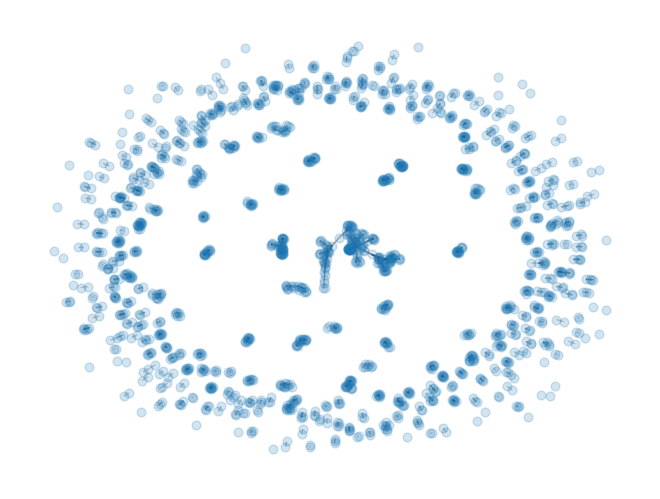

In [18]:
nx.draw(G,pos=pos, node_size=40,alpha=.2)

## Save the network as JSON

In [19]:
with open("data/output/author_network.json", 'w', encoding='utf-8') as f:
    json.dump(json_graph.node_link_data(G), f, ensure_ascii=False)

In [20]:
nx.write_gml(G, "data/output/author_network.gml")